# 機械学習をPythonで実践する-19　　～ 特徴量エンジニアリング ～

In [1]:
%load_ext autoreload
%autoreload 2
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, LabelEncoder, OneHotEncoder
# # import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,cross_val_score, KFold, RepeatedKFold,StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc,get_scorer_names,roc_auc_score
from sklearn.compose import ColumnTransformer
# from sklearn import tree
# from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from lightGBM_cv import lightGBM_classifier_cv_func
from category_encoders import TargetEncoder

%matplotlib inline
import matplotlib.pyplot as plt


## 日付データからの特徴量生成
下記のKaggleのデータを使ってやってみる。  
https://www.kaggle.com/competitions/bike-sharing-demand/data

### - Pandasの場合

In [17]:
df = pd.read_csv('../Python/sample_data/ML_sample/bike_share.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [18]:
# datetimeの型をチェック
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime列は文字列になっている。

In [19]:
#　日付形式に変換
df['datetime'] = pd.to_datetime(df['datetime'])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


datetimeに変換された。

In [21]:
# 年のカラムを追加
df['year'] = df['datetime'].dt.year

# 月のカラムを追加
df['month'] = df['datetime'].dt.month

# １年の何日目かのカラムを追加
df['dayofyear'] = df['datetime'].dt.dayofyear

# １週間の何日目か(0:月～6:日)のカラムを追加
df['dayofweek'] = df['datetime'].dt.dayofweek

# １年の何週目かのカラムを追加
df['weekofyear'] = df['datetime'].dt.isocalendar().week

# ４半期のどれかを追加
df['quater'] = df['datetime'].dt.quarter

# うるう年であるか否かを追加
df['is_leap'] = df['datetime'].dt.is_leap_year

In [23]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,dayofyear,dayofweek,weekofyear,quater,is_leap
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,52,1,False
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,52,1,False
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,52,1,False
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,52,1,False
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,52,1,False


2011/1/1にもかかわらず、weekofyearが52週目となっているが、これはisocalender()では月曜日を１週間の区切りとしているため。  
この日は土曜日なのでまだ前年の週としてカウントされている。

### - Polarsの場合

In [2]:
df = pl.read_csv('../Python/sample_data/ML_sample/bike_share.csv')
df.head()

datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
str,i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64
"""2011-01-01 00:…",1,0,0,1,9.84,14.395,81,0.0,3,13,16
"""2011-01-01 01:…",1,0,0,1,9.02,13.635,80,0.0,8,32,40
"""2011-01-01 02:…",1,0,0,1,9.02,13.635,80,0.0,5,27,32
"""2011-01-01 03:…",1,0,0,1,9.84,14.395,75,0.0,3,10,13
"""2011-01-01 04:…",1,0,0,1,9.84,14.395,75,0.0,0,1,1


strとして読み込まれてしまっているので、datetimeに変換する必要あり。  
（事前に型が分かっているのであれば、pl.read_csvの段階でdtypesを指定してしまうのが楽かも。）

In [3]:
# strからdatetimeに変換
df = df.with_columns(pl.col('datetime').str.strptime(pl.Datetime))
df.head()

datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime[μs],i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
df.with_columns([pl.col('datetime').dt.year().alias('year'),
                 pl.col('datetime').dt.month().alias('month'),
                 # １年の何日目かのカラムを追加 
                 pl.col('datetime').dt.ordinal_day().alias('day_of_year'),
                 # １週間の何日目か(1:月～7:日)のカラムを追加。pandasと違うことに注意 
                 pl.col('datetime').dt.weekday().alias('day_of_week'),
                 pl.col('datetime').dt.week().alias('week_of_year'),
                 pl.col('datetime').dt.quarter().alias('quarter'),
                 pl.col('datetime').dt.is_leap_year().alias('is_leap')
]).head()

# # 年のカラムを追加
# df['year'] = df['datetime'].dt.year

# # 月のカラムを追加
# df['month'] = df['datetime'].dt.month

# # １年の何日目かのカラムを追加
# df['dayofyear'] = df['datetime'].dt.dayofyear

# # １週間の何日目か(0:月～6:日)のカラムを追加
# df['dayofweek'] = df['datetime'].dt.dayofweek

# # １年の何週目かのカラムを追加
# df['weekofyear'] = df['datetime'].dt.isocalendar().week

# # ４半期のどれかを追加
# df['quater'] = df['datetime'].dt.quarter

# # うるう年であるか否かを追加
# df['is_leap'] = df['datetime'].dt.is_leap_year

datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day_of_year,day_of_week,week_of_year,quarter,is_leap
datetime[μs],i64,i64,i64,i64,f64,f64,i64,f64,i64,i64,i64,i32,u32,u32,u32,u32,u32,bool
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,6,52,1,false
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,6,52,1,false
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,6,52,1,false
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,6,52,1,false
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,6,52,1,false


Polarsの方がまとめて処理を書けるので楽かも。datetimeへの変換処理も上のセルにまとめて書いてもOK.  
day_of_weekの扱いは微妙に違うので注意。

## 多項式特徴量を生成

In [10]:
dtypes = {
    "species": str,
    'island': str,
    'culmen_length_mm': pl.Float32, # くちばしの長さ[mm]
    'culmen_depth_mm': pl.Float32, # くちばしの高さ[mm]
    'flipper_length_mm': pl.Float32, # 翼の長さ[mm]
    'body_mass_g': pl.Float32, # 体重[g]
    'sex': str
}

# ペンギンのデータセット読み込み。欠損値がNAとして含まれているので、null_values="NA"を指定しないと読み込みエラーになる。
df = pl.read_csv('../Python/sample_data/ML_sample/penguins_size.csv',dtypes=dtypes, null_values='NA')

# 今回は欠損値は落とす
df = df.drop_nulls()

In [12]:
df.head(1)

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
str,str,f32,f32,f32,f32,str
"""Adelie""","""Torgersen""",39.099998,18.700001,181.0,3750.0,"""MALE"""


In [11]:
# 多項式特徴量の生成。今回は2次までで定数項(バイアス項は含まない)
poly = PolynomialFeatures(degree=2, include_bias=False)

In [48]:
# 引数はPolars DFでもOKな模様
poly_length_depth = poly.fit_transform(df.select(['culmen_length_mm', 'culmen_depth_mm']))
poly_length_depth

array([[  39.09999847,   18.70000076, 1528.80988068,  731.1700013 ,
         349.69002853],
       [  39.5       ,   17.39999962, 1560.25      ,  687.29998493,
         302.75998672],
       [  40.29999924,   18.        , 1624.08993851,  725.39998627,
         324.        ],
       ...,
       [  50.40000153,   15.69999981, 2540.16015381,  791.28001434,
         246.48999401],
       [  45.20000076,   14.80000019, 2043.04006897,  668.96001991,
         219.04000565],
       [  49.90000153,   16.10000038, 2490.01015228,  803.3900436 ,
         259.21001228]])

length=X1, depth=X2とすると、  
fit_transformの戻り値は左の列から順にX1, X2, X1^2, X1*X2, X2^2を表している。

In [51]:
df = df.with_columns([
    pl.Series(poly_length_depth[:, 0]).alias('culmen_length_mm'),
    pl.Series(poly_length_depth[:, 1]).alias('culmen_depth_mm'),
    pl.Series(poly_length_depth[:, 2]).alias('culmen_length_mm^2'),
    pl.Series(poly_length_depth[:, 3]).alias('culmen_length_X_depth'),
    pl.Series(poly_length_depth[:, 4]).alias('culmen_depth_mm^2')
])

In [52]:
df.head()

species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,culmen_length_mm^2,culmen_length_X_depth,culmen_depth_mm^2
str,str,f64,f64,f32,f32,str,f64,f64,f64
"""Adelie""","""Torgersen""",39.099998,18.700001,181.0,3750.0,"""MALE""",1528.809881,731.170001,349.690029
"""Adelie""","""Torgersen""",39.5,17.4,186.0,3800.0,"""FEMALE""",1560.25,687.299985,302.759987
"""Adelie""","""Torgersen""",40.299999,18.0,195.0,3250.0,"""FEMALE""",1624.089939,725.399986,324.0
"""Adelie""","""Torgersen""",36.700001,19.299999,193.0,3450.0,"""FEMALE""",1346.890056,708.309987,372.489971
"""Adelie""","""Torgersen""",39.299999,20.6,190.0,3650.0,"""MALE""",1544.48994,809.579999,424.360016


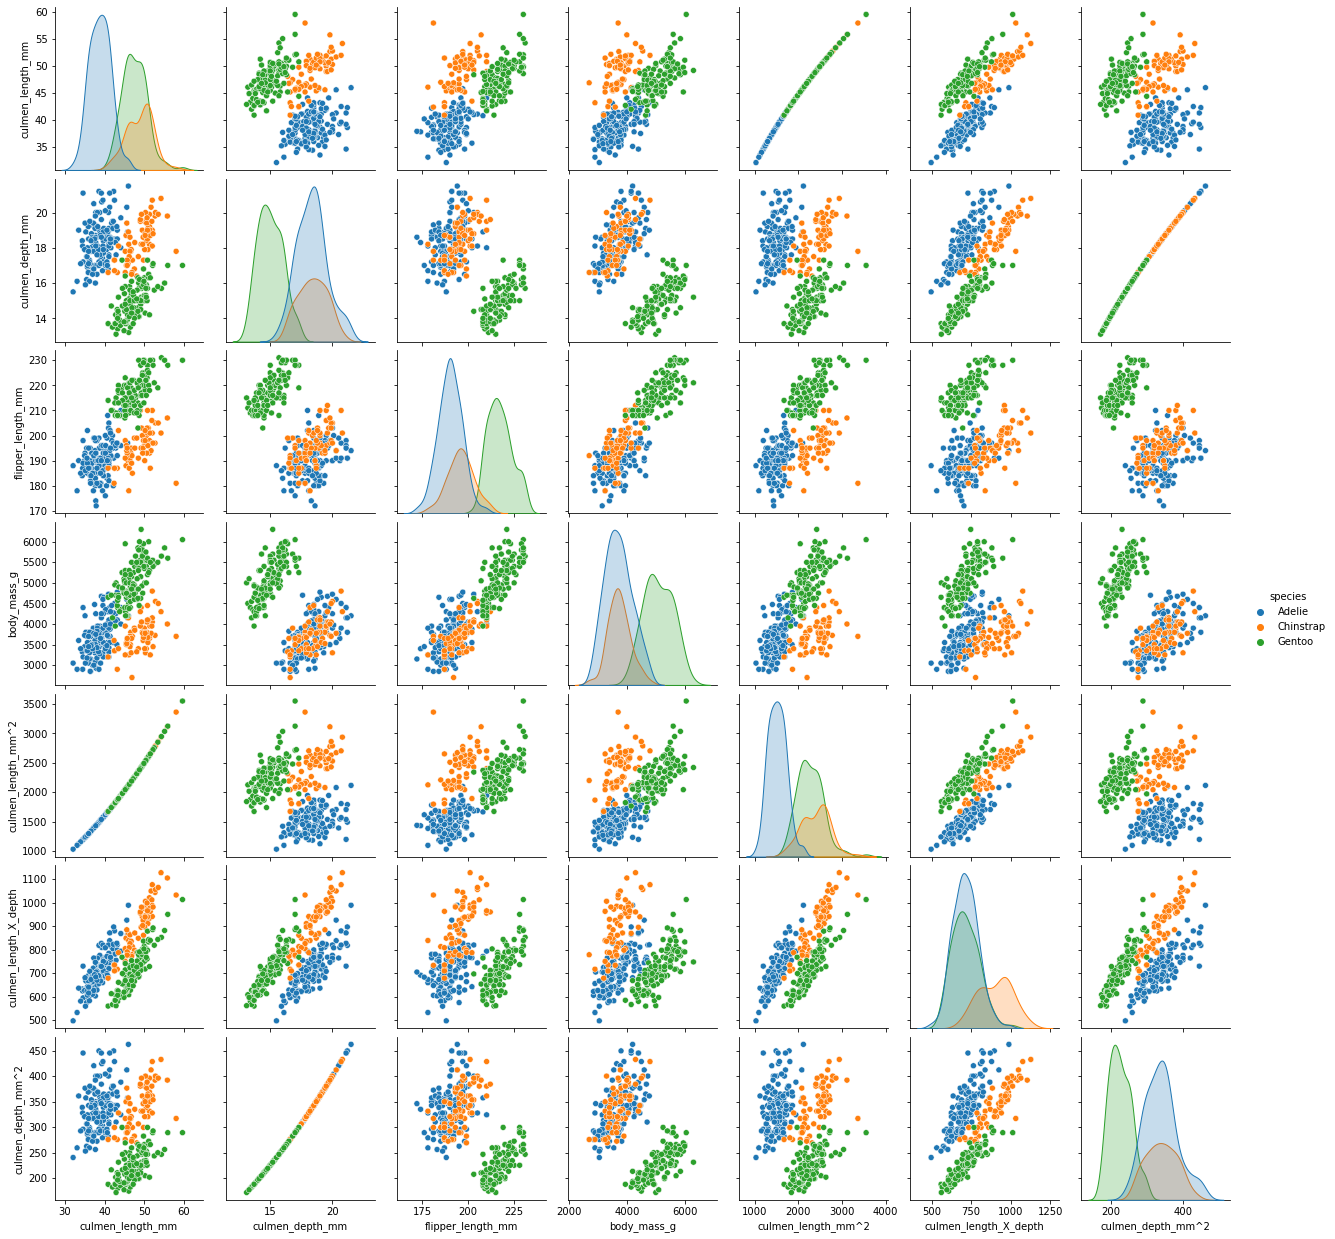

In [55]:
sns.pairplot(df.to_pandas(), hue='species')

新しく追加した特徴量（下３つ）を見ると、他の特徴量と組み合わせることにより、speciesを分けることができそうではある。  
しかし、単体だけではspeciesごとの分布が重なっているので、精度向上は難しいかも？  

## binning
数値特徴量からカテゴリカルな特徴量を生成する。

### - Pandasの場合

In [63]:
df_pd = df.to_pandas()

In [64]:
df_pd['body_mass_g_bin'] = pd.cut(df_pd['body_mass_g'], bins=10, labels=False)

In [71]:
df_pd.sort_values(by='body_mass_g')

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,culmen_length_mm^2,culmen_length_X_depth,culmen_depth_mm^2,body_mass_g_bin
184,Chinstrap,Dream,46.900002,16.600000,192.0,2700.0,FEMALE,2199.610143,778.540043,275.560013,0
58,Adelie,Biscoe,36.400002,17.100000,184.0,2850.0,FEMALE,1324.960111,622.440040,292.410013,0
52,Adelie,Biscoe,36.500000,16.600000,181.0,2850.0,FEMALE,1332.250000,605.900014,275.560013,0
110,Adelie,Torgersen,38.599998,17.000000,188.0,2900.0,FEMALE,1489.959882,656.199974,289.000000,0
92,Adelie,Dream,33.099998,16.100000,178.0,2900.0,FEMALE,1095.609899,532.909988,259.210012,0
...,...,...,...,...,...,...,...,...,...,...,...
291,Gentoo,Biscoe,45.200001,16.400000,223.0,5950.0,MALE,2043.040069,741.279995,268.959987,9
289,Gentoo,Biscoe,51.099998,16.299999,220.0,6000.0,MALE,2611.209844,832.929936,265.689975,9
328,Gentoo,Biscoe,48.799999,16.200001,222.0,6000.0,MALE,2381.439926,790.560025,262.440025,9
246,Gentoo,Biscoe,59.599998,17.000000,230.0,6050.0,MALE,3552.159818,1013.199974,289.000000,9


上記のpd.cutでは対象のカラムを小さい順に並べて10分割する。  

In [66]:
df_pd['body_mass_g_bin']

0      2
1      3
2      1
3      2
4      2
      ..
329    6
330    5
331    8
332    6
333    7
Name: body_mass_g_bin, Length: 334, dtype: int64

intとして入っているので、カテゴリとして使う際は変換する必要があるので注意

### - Polarsの場合
Polarsにも.cutはあるが、Pandasのcutのように任意のbin数で小さい順にbinningするには、  
下記のように面倒な工夫が必要。  
参考：https://pola-rs.github.io/polars/py-polars/html/reference/series/api/polars.Series.cut.html  
四分位範囲でのbinningなどはできるのでそれを使う。  
(というかそういったケースの方が多い気がする。)

In [119]:
# body_mass_gの最小値～最大値の範囲を10分割する。
bin_range = list(np.linspace(df['body_mass_g'].min(), df['body_mass_g'].max(), 10))

# bin_rangeの範囲をラベル付けするためのラベルを生成（０～１０）
labels = [str(label) for label in range(0, len(bin_range)+1)]

In [121]:
df['body_mass_g'].cut(
    bins=bin_range,
    labels=labels
)

body_mass_g,break_point,category
f64,f64,cat
2700.0,2700.0,"""0"""
2850.0,3100.0,"""1"""
2850.0,3100.0,"""1"""
2900.0,3100.0,"""1"""
2900.0,3100.0,"""1"""
2900.0,3100.0,"""1"""
2900.0,3100.0,"""1"""
2925.0,3100.0,"""1"""
3000.0,3100.0,"""1"""


break_pointは区切りの上限値。  
上記の"category"カラムをwith_columnsで元のdfに追加すればpandasと同じことはできる。